### Math 425 Fall 2025 Project 1   due: 5PM on Fri October 24

### PragyaJ

### Project Directions

- Include a report on every group member’s contribution.
- Submit the group’s well commented code used for the project with instructions on how to compile and run.
- Make a 15 to 20 minute video presentation of your results.

~~**Problem 1**~~
- [x] a
- [x] b
- [x] c

~~**Prob 2**~~
- [x] a
- [x] b
- [x] c
- ~~[ ] d~~
- ~~[ ] e~~

**Q3**
- [x] k-means -> done BUT NEED TO UPDATE DATASET song_list

? how to fill out the song list according to roster number ?

### Details:
#### (1) Wisconsin Diagnostic Breast Cancer (WDBC) datase: 
https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)

For each patient, you are given a vector a giving features computed from digitized images of a fine needle aspirate (FNA) of a breast mass for that patient. The features describe characteristics of the cell nuclei present in the image. The goal is to decide whether the cells are malignant or benign.

Here is a brief description of the way the features were computed. Ten real-valued quantities are computed for each cell nucleus:
- radius ( mean of distances from center to points on the perimeter)
- texture (standard deviation of gray-scale values)
- perimeter
- area
- smoothness (local variation in radius lengths)
- compactness (perimeter^2 / area - 1.0)
- concavity (severity of concave portions of the contour)
- concave points (number of concave portions of the contour)
- symmetry
- fractal dimension (“coastline approximation” - 1)

The mean, standard error (stderr), and a measure of the largest (worst) (mean of the largest values) of each of the features were computed for each image. Each specimen is represented by a vector a with thirty entries. 
The domain D consists of thirty strings identifying these features, e.g. "radius (mean)", "radius (stderr)", "radius (worst)", "area (mean)", and so on. Four files are provided containing data:
- **train.txt**: data for 300 patients
- **train values.txt**: Indicator for malignant speciment (+1) or benign specimen (-1)
- **validate.txt**: data for 260 points
- **validate values.txt**: Indicator for malignant specimen (+1) or benign specimen (-1)

# Problem 1

**(a) Apply k-means clustering with k = 2 to the training data. Then use the validation data to assess the accuracy of your clustering. You will need to come up with a scheme to determine the accuracy (i.e. a scheme to determine whether a patient in the validation set has a malignant tumor or a benign tumor based on the clustering).**

In [26]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

from collections import Counter # this is for mapping clusters to majority labels
import os # for file paths

# all four files stored here
data_path = "project1_data"

# Load all data files
X_train = np.loadtxt(os.path.join(data_path, "train.txt"), delimiter=",")         # training featr
y_train = np.loadtxt(os.path.join(data_path, "train_values.txt"), dtype=int)      # training label
X_val = np.loadtxt(os.path.join(data_path, "validate.txt"), delimiter=",")        # vali featr
y_val = np.loadtxt(os.path.join(data_path, "validate_values.txt"), dtype=int)     # vali label

print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)

Training data shape: (300, 30)
Validation data shape: (260, 30)


In [27]:
# Scaling the features for KMeans
# standardizing/normalizing the data across - > prevent larger features from dominating the clustering
# ex: in data "radius" & "fractal dimension" are on diff. scales

scaler = StandardScaler()   # removes the mean and scales to the unit varience

# fitting on the data and transforming
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [28]:
# KMeans algorithm (k = 2)

kmeans = KMeans(n_clusters=2, n_init=10, random_state=42)  # 2 clusters for malignant vs. benign
train_cluster_labels = kmeans.fit_predict(X_train_scaled) 

# should ouput 0 or 1 on training -> need to fix back to +1/-1

In [29]:
# Mapping clusters to the above cluster labels (either +1 or -1)

def map_clusters_to_labels(cluster_labels, true_labels):
    label_mapping = {}
    for cluster in [0, 1]:
        indices = np.where(cluster_labels == cluster)[0]
        votes = true_labels[indices]
        majority = Counter(votes).most_common(1)[0][0]  # finding the common label
        label_mapping[cluster] = majority
    return label_mapping

label_mapping = map_clusters_to_labels(train_cluster_labels, y_train) #mapp from cluster # to predict labels
print("Cluster to label mapping:", label_mapping)

Cluster to label mapping: {0: np.int64(-1), 1: np.int64(1)}


In [30]:
# predicting on the validation data -> which cluster it goes to

val_cluster_preds = kmeans.predict(X_val_scaled)
y_pred = np.array([label_mapping[cluster] for cluster in val_cluster_preds])

In [31]:
# evaluating the accuracy using K-Means

accuracy = accuracy_score(y_val, y_pred) # % of correctly classified (given data vs predict by algo)
print(f"Validation Accuracy using K-Means (k=2): {accuracy * 100:.2f}%")

Validation Accuracy using K-Means (k=2): 95.00%


**(b) Embed the data in dimensions d ∈ {5, 10, 20} using Gaussian matrix embedding and rerun k-means on the lower dimensional data set. What is the accuracy of the clustering for each dimension d? What is the computational time averaged over 500 independent runs?**

In [32]:
# basically need to reduce training & validation to d ∈ {5, 10, 20} using Guassian Random Projection
from sklearn.random_projection import GaussianRandomProjection
import time

# run one trial first -> guassian proj + K-Means + accuracy of that
def run_kmeans_with_projection(X_train, y_train, X_val, y_val, d): 

    start = time.time() # start timer
    
    projector = GaussianRandomProjection(n_components=d) # guassian proj to reduce dimensionality
    X_train_proj = projector.fit_transform(X_train)
    X_val_proj = projector.transform(X_val)

    # k-means on proj. data
    kmeans = KMeans(n_clusters=2, n_init=10, random_state=None)
    cluster_labels = kmeans.fit_predict(X_train_proj) # new clusters labels
    # map new clusters -> new lables -> by prev. training labels
    label_mapping = map_clusters_to_labels(cluster_labels, y_train)

    # predict valid. cluster labels
    val_cluster_preds = kmeans.predict(X_val_proj)
    y_pred = np.array([label_mapping[cluster] for cluster in val_cluster_preds]) # map to actual labels

    acc = accuracy_score(y_val, y_pred)
    # elapsed time counter(s)
    elapsed = time.time() - start
    return acc, elapsed

In [33]:
dims = [5, 10, 20]
num_trials = 500
results = {}      # empty dictionary to store

from tqdm import trange # need a progress bar
for d in dims:
    print(f"running gaussian proj. with d = {d}...")
    acc_list = []   # same, empty lists to store
    time_list = []

    for _ in trange(num_trials):
        acc, t = run_kmeans_with_projection(X_train_scaled, y_train, X_val_scaled, y_val, d) #1 trial run = proj -> cluster -> predict -> eval => repeat
        acc_list.append(acc) # new acc + time each trial
        time_list.append(t)

    avg_acc = np.mean(acc_list) # final avg of all
    avg_time = np.mean(time_list)

    results[d] = {
        'avg_accuracy': avg_acc,  # appending to dictionary
        'avg_time_sec': avg_time
    }

    print(f"✔︎ d = {d}: avg accuracy = {avg_acc*100:.2f}%, avg time = {avg_time:.4f} sec")


running gaussian proj. with d = 5...


  1%|          | 4/500 [00:00<00:15, 32.93it/s]0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
100%|██████████| 500/500 [00:03<00:00, 146.98it/s]


✔︎ d = 5: avg accuracy = 87.10%, avg time = 0.0068 sec
running gaussian proj. with d = 10...


100%|██████████| 500/500 [00:02<00:00, 209.31it/s]


✔︎ d = 10: avg accuracy = 90.83%, avg time = 0.0048 sec
running gaussian proj. with d = 20...


100%|██████████| 500/500 [00:02<00:00, 242.21it/s]

✔︎ d = 20: avg accuracy = 93.88%, avg time = 0.0041 sec


In [34]:
print("\n final summary:")
for d, stats in results.items():
    print(f"d = {d}: accuracy = {stats['avg_accuracy']*100:.2f}%, avg Time = {stats['avg_time_sec']:.4f} sec")


 final summary:
d = 5: accuracy = 87.10%, avg Time = 0.0068 sec
d = 10: accuracy = 90.83%, avg Time = 0.0048 sec
d = 20: accuracy = 93.88%, avg Time = 0.0041 sec


In [35]:
# accuracy is improving w/ dimensionality increasing
# comp time low = good
# the 20 d guass proj. is almost reaching the same performance as the 30 d from part 1(a)

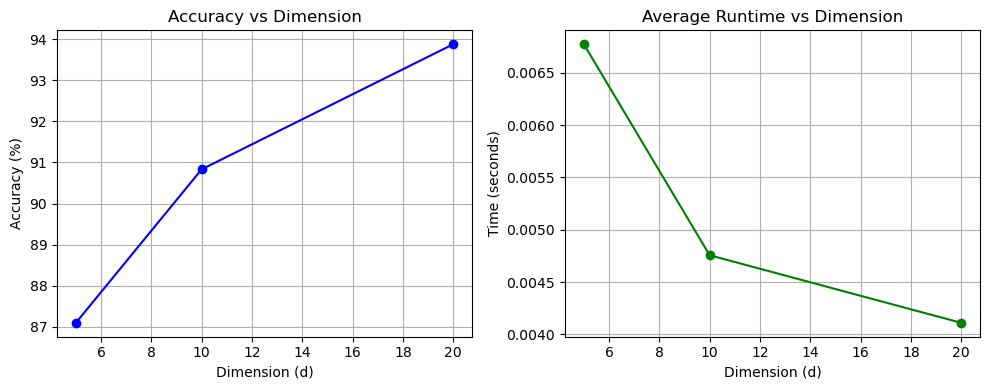

In [36]:
# visualizing the results for explanation on the video/report

import matplotlib.pyplot as plt

dims = [5, 10, 20]
accs = [results[d]['avg_accuracy']*100 for d in dims]
times = [results[d]['avg_time_sec'] for d in dims]

plt.figure(figsize=(10, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(dims, accs, marker='o', color='blue')
plt.title("Accuracy vs Dimension")
plt.xlabel("Dimension (d)")
plt.ylabel("Accuracy (%)")
plt.grid(True)

# Time Plot
plt.subplot(1, 2, 2)
plt.plot(dims, times, marker='o', color='green')
plt.title("Average Runtime vs Dimension")
plt.xlabel("Dimension (d)")
plt.ylabel("Time (seconds)")
plt.grid(True)

plt.tight_layout()
plt.show()

**(c) Embed the data in dimensions d ∈ {5, 10, 20} using the sparse random rrojection and rerun k-means on the lower dimensional data set. What is the accuracy of the clustering for each dimension d? What is the computational time averaged over 500 independent runs?**

In [37]:

# same code as part 1(b)
# just changed gauss proj. to sparse random proj.

from sklearn.random_projection import SparseRandomProjection

# run one trial first -> guassian proj + K-Means + accuracy of that
def run_kmeans_with_sparse_projection(X_train, y_train, X_val, y_val, d):
   
    start = time.time() # start timer

    projector = SparseRandomProjection(n_components=d) # sparse proj to lower dimensionality
    X_train_proj = projector.fit_transform(X_train)
    X_val_proj = projector.transform(X_val)

    # k-means on proj. data
    kmeans = KMeans(n_clusters=2, n_init=10, random_state=None)
    cluster_labels = kmeans.fit_predict(X_train_proj) # new clusters labels
    # map new clusters -> new lables -> by prev. training labels
    label_mapping = map_clusters_to_labels(cluster_labels, y_train)

    # predict valid. cluster labels
    val_cluster_preds = kmeans.predict(X_val_proj)
    y_pred = np.array([label_mapping[cluster] for cluster in val_cluster_preds]) # map to actual labels

    # elapsed time counter(s)
    acc = accuracy_score(y_val, y_pred)
    elapsed = time.time() - start
    return acc, elapsed

In [38]:
dims = [5, 10, 20]
num_trials = 500

sparse_results = {}      # empty dictionary to store

from tqdm import trange
for d in dims:
    print(f"running sparse proj. with d = {d}...")
    acc_list = []   # same, empty lists to store
    time_list = []

    for _ in trange(num_trials):
        acc, t = run_kmeans_with_sparse_projection(X_train_scaled, y_train, X_val_scaled, y_val, d) #1 trial run = proj -> cluster -> predict -> eval => repeat
        acc_list.append(acc) # new acc + time each trial
        time_list.append(t)

    avg_acc = np.mean(acc_list) # final avg of all
    avg_time = np.mean(time_list)

    sparse_results[d] = {
        'avg_accuracy': avg_acc,  # appending to dictionary
        'avg_time_sec': avg_time
    }

    print(f"✔︎ d = {d}: avg accuracy = {avg_acc*100:.2f}%, avg time = {avg_time:.4f} sec")


running sparse proj. with d = 5...


100%|██████████| 500/500 [00:03<00:00, 150.15it/s]


✔︎ d = 5: avg accuracy = 85.91%, avg time = 0.0066 sec
running sparse proj. with d = 10...


100%|██████████| 500/500 [00:02<00:00, 193.53it/s]


✔︎ d = 10: avg accuracy = 90.70%, avg time = 0.0051 sec
running sparse proj. with d = 20...


100%|██████████| 500/500 [00:02<00:00, 227.13it/s]

✔︎ d = 20: avg accuracy = 93.76%, avg time = 0.0044 sec


In [39]:
print("\n final summary on sparse proj.:")
for d, stats in sparse_results.items():
    print(f"d = {d}: accuracy = {stats['avg_accuracy']*100:.2f}%, avg Time = {stats['avg_time_sec']:.4f} sec")


 final summary on sparse proj.:
d = 5: accuracy = 85.91%, avg Time = 0.0066 sec
d = 10: accuracy = 90.70%, avg Time = 0.0051 sec
d = 20: accuracy = 93.76%, avg Time = 0.0044 sec


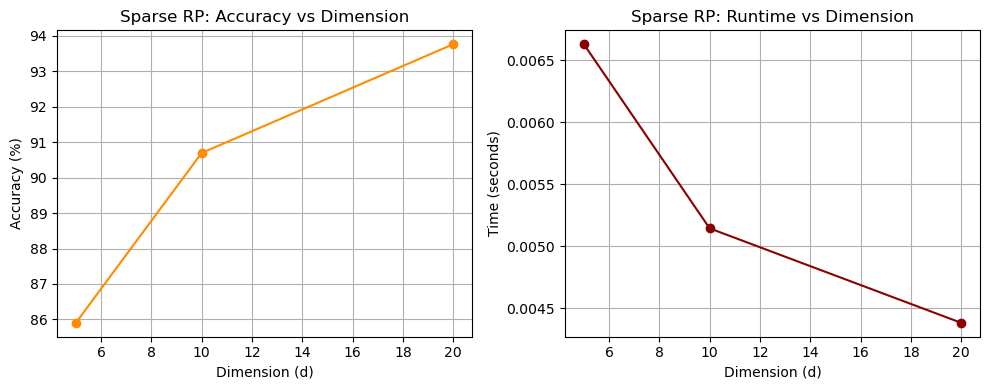

In [40]:
sparse_accs = [sparse_results[d]['avg_accuracy']*100 for d in dims]
sparse_times = [sparse_results[d]['avg_time_sec'] for d in dims]

plt.figure(figsize=(10, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(dims, sparse_accs, marker='o', color='darkorange')
plt.title("Sparse RP: Accuracy vs Dimension")
plt.xlabel("Dimension (d)")
plt.ylabel("Accuracy (%)")
plt.grid(True)

# Runtime plot
plt.subplot(1, 2, 2)
plt.plot(dims, sparse_times, marker='o', color='darkred')
plt.title("Sparse RP: Runtime vs Dimension")
plt.xlabel("Dimension (d)")
plt.ylabel("Time (seconds)")
plt.grid(True)

plt.tight_layout()
plt.show()

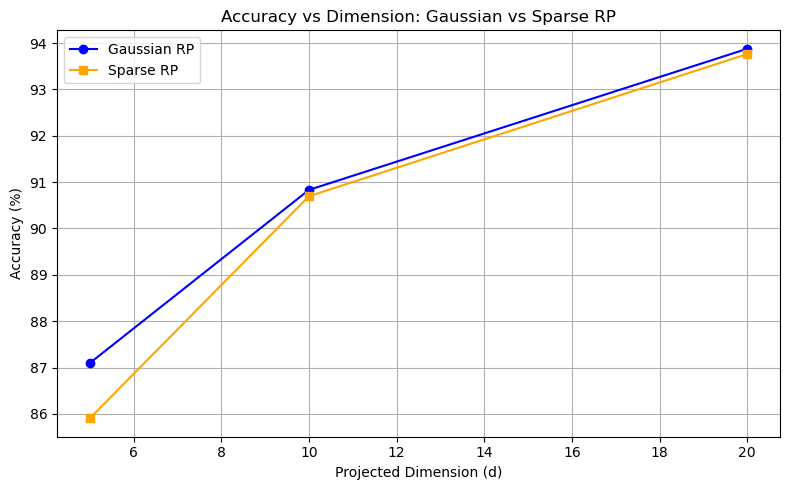

In [41]:
# need to compare guass vs sparse

plt.figure(figsize=(8, 5))

dims = [5, 10, 20]
gauss_accs = [results[d]['avg_accuracy']*100 for d in dims]
sparse_accs = [sparse_results[d]['avg_accuracy']*100 for d in dims]

plt.plot(dims, gauss_accs, marker='o', label='Gaussian RP', color='blue')
plt.plot(dims, sparse_accs, marker='s', label='Sparse RP', color='orange')

plt.title("Accuracy vs Dimension: Gaussian vs Sparse RP")
plt.xlabel("Projected Dimension (d)")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [42]:
# so guass slightly better > than sparse in higher dims, BUT sparse > guass in lower dims
# at a lower dims middlepoint they are similar

# Problem 2

- Read in the data in *train.txt* into a matrix A whose rows correspond to the data for each patient in the data set. The elements in a row correspond to the 30 features measured for a patient.
- Read in the data in *train values.txt* into a vector $b$ whose domain is the set of patients and $b_i$ is 1 if the specimen of patient $i$ is malignant and it’s -1 if the specimen is benign.

#### least sqrs: $ min_x || Ax - b||_2^2$
#### QR decomp: $ x = R^{-1} Q^T b $

In [43]:
# (1) load training data: train.txt -> features -> A, train_values -> lables -> b 

# (2) fitting the linear model using least squares solution

# (3) then apply QR decomp. to get optimal x

# x -> weight vector

**(a) Use the QR algorithm to find the least-squares linear model for the data.**

In [44]:
# training data and labels
X_train = np.loadtxt(os.path.join(data_path, "train.txt"), delimiter=",")
y_train = np.loadtxt(os.path.join(data_path, "train_values.txt"), dtype=int)

# standardize/normalize featrs -> imprt for numerical stability
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [45]:
# computing QR decomposition: A = QR
Q, R = np.linalg.qr(X_train_scaled)

# compute least squares solution: x = R^{-1} Q^T b
x_ls = np.linalg.solve(R, Q.T @ y_train)

In [46]:
# 30 coeffs in total

# print first few coefficients
#print("first 6 coefficients of least squares solution:")
#print(x_ls[:6])

print("all coefficients of least squares solution:")
print(x_ls[:30])

all coefficients of least squares solution:
[-2.15322136  0.10496665  1.91466725  0.2046981   0.12170976 -0.51890037
  0.03087999  0.14276811 -0.09424895  0.04956945  0.32869246  0.02369661
 -0.13144432 -0.07876635  0.09226428  0.05727017 -0.15459532  0.12226035
 -0.07025935 -0.09478202  1.65752714  0.05136566  0.30397922 -1.39947321
 -0.05616157 -0.07515524  0.11741832  0.13410353  0.2139487   0.21238152]


In [47]:
# so large + coeffs mean feature -> predicting malignant tumor (+1)
# and large - coeff means -> predict benign (-1)
# if in the middle/small coeff -> little classification

**(b) Apply the linear model from (a) to the data set *validate.txt* and predict the malignancy of the tissues. You will have to define a classifier function:
$$
C(y) = \begin{cases}
+1 & \text{if the prediction is non-negative} \\
-1 & \text{otherwise }
\end{cases}
$$**

In [48]:
# x_ls becomes the weight vector x

# validation data and labels
X_val = np.loadtxt(os.path.join(data_path, "validate.txt"), delimiter=",")
y_val = np.loadtxt(os.path.join(data_path, "validate_values.txt"), dtype=int)

# standardizing using training set's scaler
X_val_scaled = scaler.transform(X_val)

In [49]:
# predict raw values -> y_hat = A*x
y_pred_raw = X_val_scaled @ x_ls

# classifier function: +1 if ≥ 0, else -1
y_pred = np.where(y_pred_raw >= 0, 1, -1)

In [50]:
from sklearn.metrics import accuracy_score

accuracy_val = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy_val * 100:.2f}%")

Validation Accuracy: 97.31%


In [51]:
# accuracy is better than k-means/guass/sparse from prob. 1
# bc least sqr = supervised = directly training on data VS. k-means = unsupervised

**(c) What is the percentage of samples that are incorrectly classified? Is it greater or smaller than the success rate on the training data?**

In [52]:
# determing overfit or underfit on model to training data fit

# predicting  on the training set
y_train_pred_raw = X_train_scaled @ x_ls
y_train_pred = np.where(y_train_pred_raw >= 0, 1, -1)

# find training acc
accuracy_train = accuracy_score(y_train, y_train_pred)

print(f"training acc: {accuracy_train * 100:.2f}%")
print(f"validation acc: {accuracy_val * 100:.2f}%")


training acc: 96.33%
validation acc: 97.31%


In [53]:
# key finding = both % high = model good
# valid slightly > training so model will be good on unseen data
# no over/under fitting yet

**(d) Embed the data in dimensions *d* ∈ {5, 10, 20} using Gaussian matrix embedding and repeat the work in (a),(b) and (c) for each lower dimension *d*. What is the computational time averaged over 500 independent runs?**

In [54]:
# similar to 1(b)/1(c) but instead using least-sqrs (not k-menas)


# proj. data using gauss rand.proj. -> solve least sqr by QR decomp -> acc on valid. datapoints
def run_least_squares_with_gaussian_projection(X_train, y_train, X_val, y_val, d):
   
    start = time.time()

    projector = GaussianRandomProjection(n_components=d) #g. r. p.
    X_train_proj = projector.fit_transform(X_train)
    X_val_proj = projector.transform(X_val)

    # -> solve least sqr by QR decomp ->
    Q, R = np.linalg.qr(X_train_proj)
    x_ls = np.linalg.solve(R, Q.T @ y_train)

    # predict on validation set
    y_val_pred_raw = X_val_proj @ x_ls
    y_val_pred = np.where(y_val_pred_raw >= 0, 1, -1)

    acc = accuracy_score(y_val, y_val_pred)
    elapsed = time.time() - start
    return acc, elapsed

In [55]:
# copying structure from 1(b)

dims = [5, 10, 20]
num_trials = 500

ls_gaussian_results = {}

for d in dims:
    print(f"\nRunning Least Squares with Gaussian Projection (d = {d})...")
    
    acc_list = []
    time_list = []

    for _ in range(num_trials):
        acc, t = run_least_squares_with_gaussian_projection(X_train_scaled, y_train, X_val_scaled, y_val, d)
        acc_list.append(acc)
        time_list.append(t)

    avg_acc = np.mean(acc_list)
    avg_time = np.mean(time_list)

    ls_gaussian_results[d] = {
        'avg_accuracy': avg_acc,
        'avg_time_sec': avg_time
    }

    print(f"✔︎ d = {d}: Accuracy = {avg_acc*100:.2f}%, Avg Time = {avg_time:.4f} sec")


Running Least Squares with Gaussian Projection (d = 5)...
✔︎ d = 5: Accuracy = 91.74%, Avg Time = 0.0004 sec

Running Least Squares with Gaussian Projection (d = 10)...
✔︎ d = 10: Accuracy = 96.24%, Avg Time = 0.0003 sec

Running Least Squares with Gaussian Projection (d = 20)...
✔︎ d = 20: Accuracy = 97.28%, Avg Time = 0.0004 sec


In [56]:
# really really fast compared to prob 1 times AND great acc %s
#20 d and 30 d almost same

In [57]:
print("\n final Summary – Least Squares w/ Gauss. proj.:")
for d, stats in ls_gaussian_results.items():
    print(f"d = {d}: accuracy = {stats['avg_accuracy']*100:.2f}%, avg. time = {stats['avg_time_sec']:.4f} sec")


 final Summary – Least Squares w/ Gauss. proj.:
d = 5: accuracy = 91.74%, avg. time = 0.0004 sec
d = 10: accuracy = 96.24%, avg. time = 0.0003 sec
d = 20: accuracy = 97.28%, avg. time = 0.0004 sec


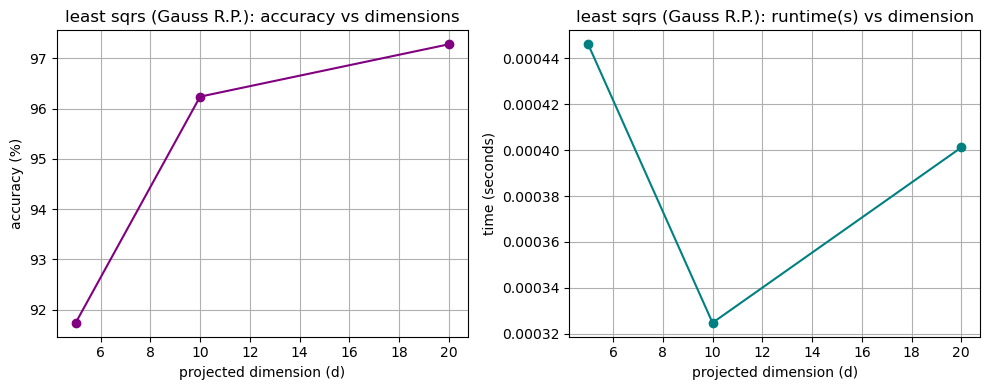

In [58]:
# comparing ls trend
import matplotlib.pyplot as plt

dims = [5, 10, 20]
accs = [ls_gaussian_results[d]['avg_accuracy']*100 for d in dims]
times = [ls_gaussian_results[d]['avg_time_sec'] for d in dims]

plt.figure(figsize=(10, 4))

# acc
plt.subplot(1, 2, 1)
plt.plot(dims, accs, marker='o', color='purple')
plt.title("least sqrs (Gauss R.P.): accuracy vs dimensions")
plt.xlabel("projected dimension (d)")
plt.ylabel("accuracy (%)")
plt.grid(True)

# sec
plt.subplot(1, 2, 2)
plt.plot(dims, times, marker='o', color='teal')
plt.title("least sqrs (Gauss R.P.): runtime(s) vs dimension")
plt.xlabel("projected dimension (d)")
plt.ylabel("time (seconds)")
plt.grid(True)

plt.tight_layout()
plt.show()

**(e) Embed the data in dimensions *d* ∈ {5, 10, 20} using sparse random projection and repeat the work in (a), (b) and (c) for each lower dimension *d*. What is the computational time averaged over 500 independent runs?**

In [59]:
# building off of 2(d) above -> replaced guass w/ sparse

In [60]:
def run_least_squares_with_sparse_projection(X_train, y_train, X_val, y_val, d):
    
    start = time.time()

    # sparse RP
    projector = SparseRandomProjection(n_components=d)
    X_train_proj = projector.fit_transform(X_train)
    X_val_proj = projector.transform(X_val)
    
    # -> solve least sqr by QR decomp ->
    Q, R = np.linalg.qr(X_train_proj)
    #x_ls = np.linalg.solve(R, Q.T @ y_train) -> was giving LinAlgError: Singular matrix ERROR
    # using psedo-inverse so even if R appears singular/non-invertible -> least sqr works
    x_ls = np.linalg.pinv(R) @ Q.T @ y_train 
    
    
    # predict on validation set
    y_val_pred_raw = X_val_proj @ x_ls
    y_val_pred = np.where(y_val_pred_raw >= 0, 1, -1)

    acc = accuracy_score(y_val, y_val_pred)
    elapsed = time.time() - start
    return acc, elapsed

In [61]:
dims = [5, 10, 20]
num_trials = 500
ls_sparse_results = {}

for d in dims:
    print(f"\n Running Least Squares with Sparse RP (d = {d})...")

    acc_list = []
    time_list = []

    for _ in range(num_trials):
        acc, t = run_least_squares_with_sparse_projection(X_train_scaled, y_train, X_val_scaled, y_val, d)
        acc_list.append(acc)
        time_list.append(t)

    avg_acc = np.mean(acc_list)
    avg_time = np.mean(time_list)
    ls_sparse_results[d] = {
        'avg_accuracy': avg_acc,
        'avg_time_sec': avg_time
    }

    print(f"✔︎ d = {d}: accuracy = {avg_acc*100:.2f}%, avg Time = {avg_time:.4f} sec")


 Running Least Squares with Sparse RP (d = 5)...
✔︎ d = 5: accuracy = 92.45%, avg Time = 0.0005 sec

 Running Least Squares with Sparse RP (d = 10)...
✔︎ d = 10: accuracy = 96.22%, avg Time = 0.0005 sec

 Running Least Squares with Sparse RP (d = 20)...
✔︎ d = 20: accuracy = 97.28%, avg Time = 0.0006 sec


In [62]:
# same high acc and speed is still good

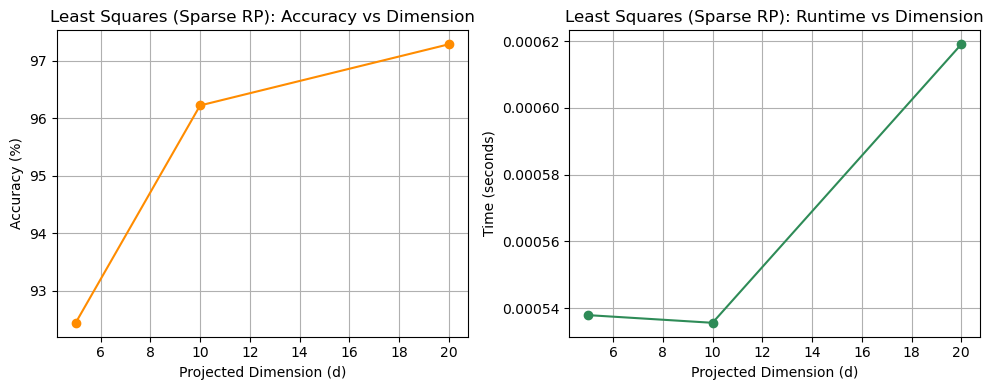

In [63]:
# sparse trends

dims = [5, 10, 20]
accs_sparse = [ls_sparse_results[d]['avg_accuracy']*100 for d in dims]
times_sparse = [ls_sparse_results[d]['avg_time_sec'] for d in dims]

plt.figure(figsize=(10, 4))

# acc
plt.subplot(1, 2, 1)
plt.plot(dims, accs_sparse, marker='o', color='darkorange')
plt.title("Least Squares (Sparse RP): Accuracy vs Dimension")
plt.xlabel("Projected Dimension (d)")
plt.ylabel("Accuracy (%)")
plt.grid(True)

# runtime
plt.subplot(1, 2, 2)
plt.plot(dims, times_sparse, marker='o', color='seagreen')
plt.title("Least Squares (Sparse RP): Runtime vs Dimension")
plt.xlabel("Projected Dimension (d)")
plt.ylabel("Time (seconds)")
plt.grid(True)

plt.tight_layout()
plt.show()

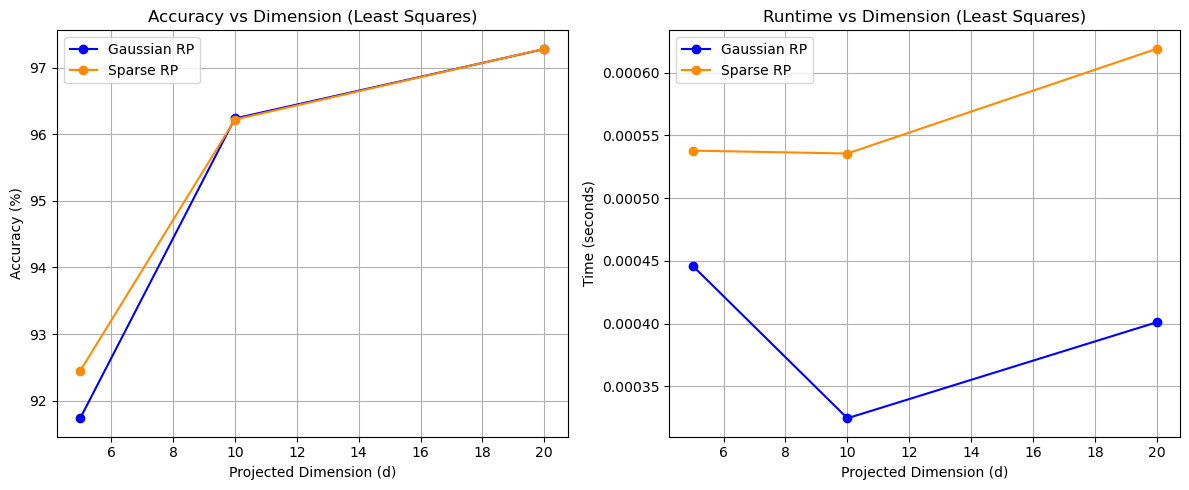

In [64]:
# comparing GRP vs sparse

dims = [5, 10, 20]
# aacc
accs_gauss = [ls_gaussian_results[d]['avg_accuracy'] * 100 for d in dims]
accs_sparse = [ls_sparse_results[d]['avg_accuracy'] * 100 for d in dims]
# runtime
times_gauss = [ls_gaussian_results[d]['avg_time_sec'] for d in dims]
times_sparse = [ls_sparse_results[d]['avg_time_sec'] for d in dims]

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# acc Comparison
plt.subplot(1, 2, 1)
plt.plot(dims, accs_gauss, marker='o', label='Gaussian RP', color='blue')
plt.plot(dims, accs_sparse, marker='o', label='Sparse RP', color='darkorange')
plt.title("Accuracy vs Dimension (Least Squares)")
plt.xlabel("Projected Dimension (d)")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()

# runtime Comparison
plt.subplot(1, 2, 2)
plt.plot(dims, times_gauss, marker='o', label='Gaussian RP', color='blue')
plt.plot(dims, times_sparse, marker='o', label='Sparse RP', color='darkorange')
plt.title("Runtime vs Dimension (Least Squares)")
plt.xlabel("Projected Dimension (d)")
plt.ylabel("Time (seconds)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [65]:
# note y axis for runtime plot, differences of ~0.0009 seconds

# Problem 3

**Apply k-means to the class music data songList.xlsx and use Class Roster to group the class into 8 distinct music clusters.**


In [66]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

# --- Load data ---
songs_path   = "MATH425_songList.xlsx"
roster_path  = "MATH425_Fall2025_roster - Copy.xlsx"

song_df = pd.read_excel(songs_path)

# Expect columns: ["Song", "Artist", <student1>, <student2>, ...]
ratings = song_df.set_index("Song").iloc[:, 1:]   # keep only student rating columns
ratings = ratings.fillna(0)
X = ratings.T.copy()
n_students = X.shape[0]

# Artist lookup
song_to_artist = song_df.set_index("Song")["Artist"]

# --- Load and align roster ---
roster = pd.read_excel(roster_path, header=None, names=["FullName"]).copy()

if len(roster) < n_students:
    roster = pd.concat(
        [roster, pd.DataFrame({"FullName": ["(missing)"] * (n_students - len(roster))})],
        ignore_index=True
    )
else:
    roster = roster.iloc[:n_students].reset_index(drop=True)

assert len(roster) == n_students, "Roster length and number of student columns do not match."

# --- KMeans clustering ---
kmeans = KMeans(n_clusters=8, init="k-means++", n_init=10, random_state=0)
clusters = kmeans.fit_predict(X.values)
centroids = kmeans.cluster_centers_

cluster_df = pd.DataFrame({
    "StudentColumn": X.index,
    "FullName": roster["FullName"].values,
    "Cluster": clusters
})

# --- Recommend based on centroid ---
def recommend_from_centroid(student_idx):
    """
    Recommend the highest-weight song from the student's cluster centroid
    that they have rated 0. If all songs are rated, print a message.
    """
    cluster_id = cluster_df.loc[student_idx, "Cluster"]
    centroid = centroids[cluster_id]

    # Songs sorted by centroid weight (descending)
    sorted_songs = np.array(X.columns)[np.argsort(-centroid)]

    student_ratings = X.iloc[student_idx]

    # Recommend the first song in centroid order that student rated 0
    for song in sorted_songs:
        if student_ratings[song] == 0:
            return song, song_to_artist.get(song, "(unknown)")

    # If student has rated every song
    return None, None

# Per-student recommendations
recommendations = []
for i in range(len(X)):
    song, artist = recommend_from_centroid(i)
    recommendations.append((song, artist))

cluster_df["RecommendedSong"] = [s for s, _ in recommendations]
cluster_df["RecommendedArtist"] = [a for _, a in recommendations]

# --- Print results ---
for c in sorted(cluster_df["Cluster"].unique()):
    print(f"\nCluster {c + 1}")
    group = cluster_df[cluster_df["Cluster"] == c]
    for _, row in group.iterrows():
        if row["RecommendedSong"]:
            print(f" - {row['FullName']}:\t {row['RecommendedSong']} — {row['RecommendedArtist']}")
        else:
            print(f" - {row['FullName']}:\t (has rated every song — no new recommendation)")



Cluster 1
 - Aviles,Francis Jake:	 A Sky Full Of Stars — Coldplay
 - Boykin,Dominique Isaiah:	 A Sky Full Of Stars — Coldplay
 - Dacumos,Daniel Jose Santos:	 A Sky Full Of Stars — Coldplay
 - Dominguez,Mario:	 Take On Me — A-Ha
 - Godinez,Salvador:	 A Sky Full Of Stars — Coldplay
 - Grossman, Aditi:	 A Sky Full Of Stars — Coldplay
 - Jha,Pragya:	 A Sky Full Of Stars — Coldplay
 - Khatri,Kiran:	 Cupid (Twin Version) — Fifty Fifty
 - Le,Brandon:	 A Sky Full Of Stars — Coldplay
 - Luong,Austin:	 Thunderstruck — Ac/Dc
 - Muratov,Muzaffarbek:	 A Sky Full Of Stars — Coldplay
 - Patel,Kartik Haribhai:	 A Sky Full Of Stars — Coldplay
 - Pineda,Andres David:	 A Sky Full Of Stars — Coldplay
 - Sandoval,Angel Trinidad:	 Thunderstruck — Ac/Dc
 - Seck,Abdoukhadr:	 A Sky Full Of Stars — Coldplay
 - Singh,Darshveer:	 A Sky Full Of Stars — Coldplay
 - Thompson,Michael John:	 Cupid (Twin Version) — Fifty Fifty
 - Wijaya,Hansley:	 A Sky Full Of Stars — Coldplay
 - Zhu,Breanna:	 A Sky Full Of Stars — Co